In [1]:
library(tidyverse)
library(modelr)
options(na.action = na.warn)

library(nycflights13)
library(lubridate)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




### 낮은 품질의 다이아몬드가 더 비싼 이유

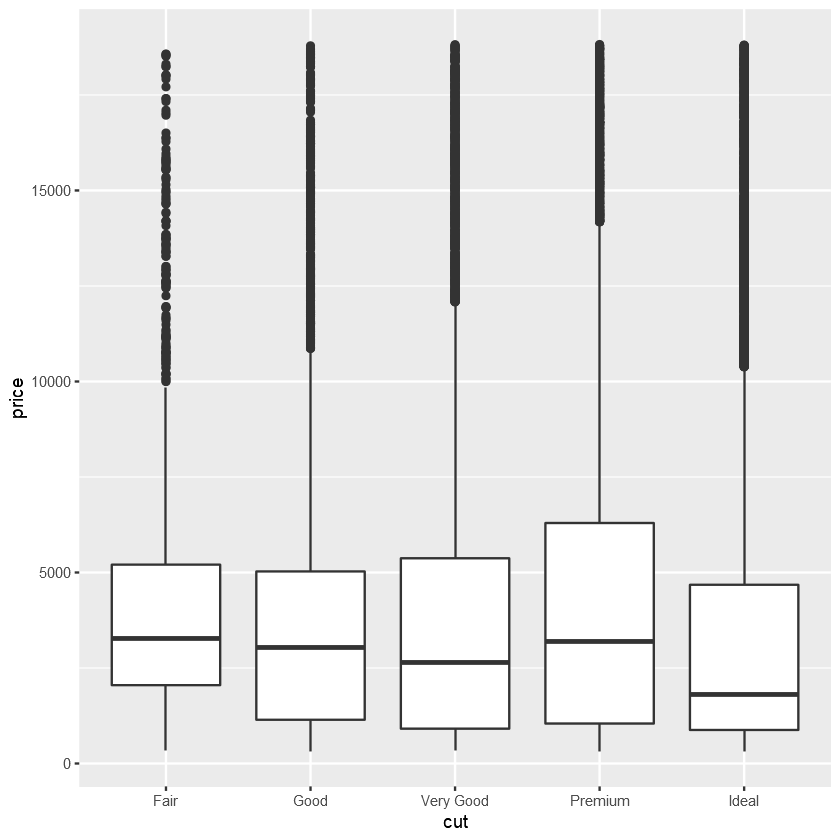

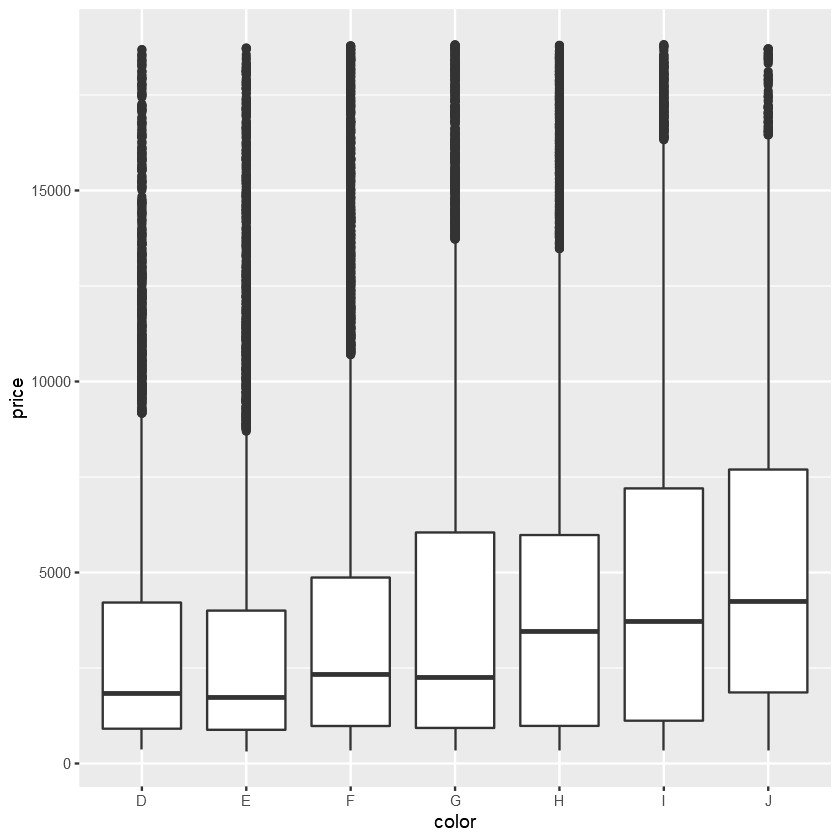

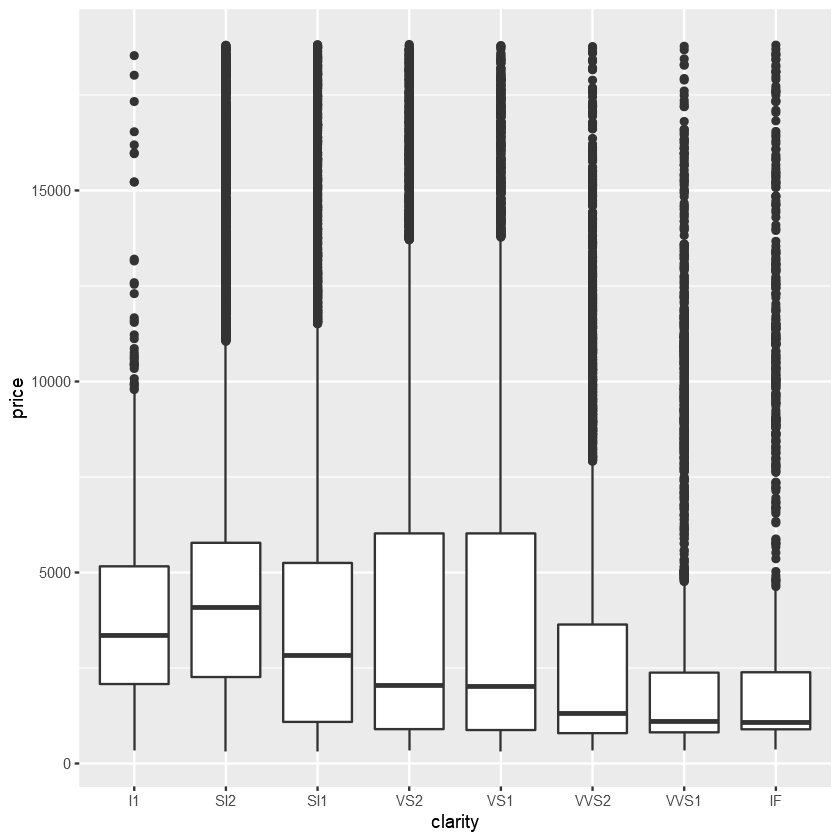

In [2]:
ggplot(diamonds, aes(cut, price)) + geom_boxplot()
ggplot(diamonds, aes(color, price)) + geom_boxplot()
ggplot(diamonds, aes(clarity, price)) + geom_boxplot()

### 가격과 캐럿

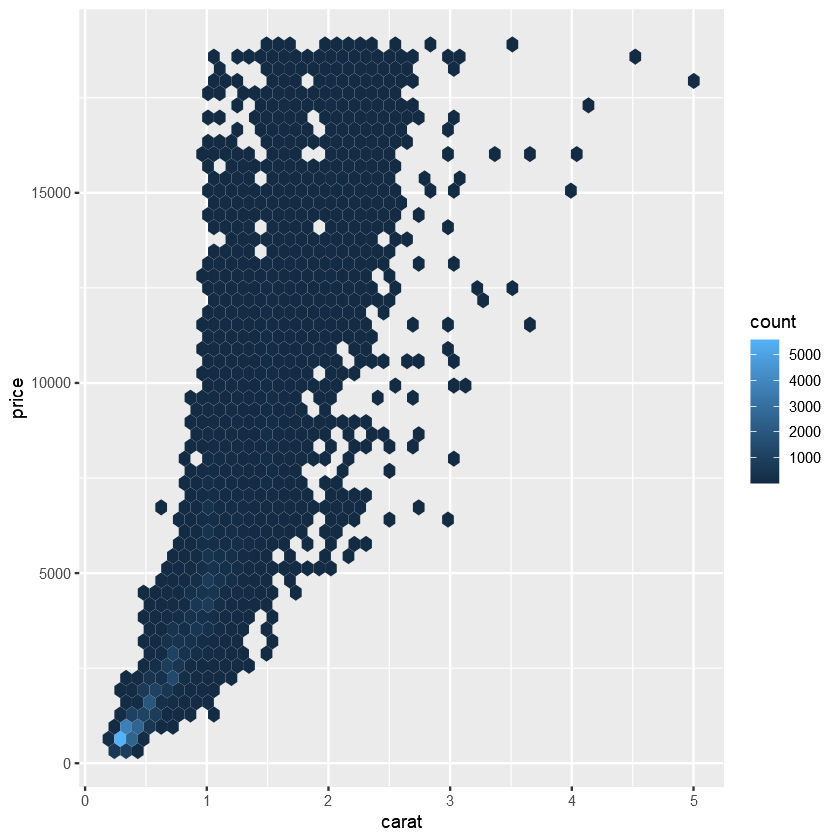

In [3]:
ggplot(diamonds, aes(carat, price)) + geom_hex(bins = 50)

#### carat과 price의 로그변환

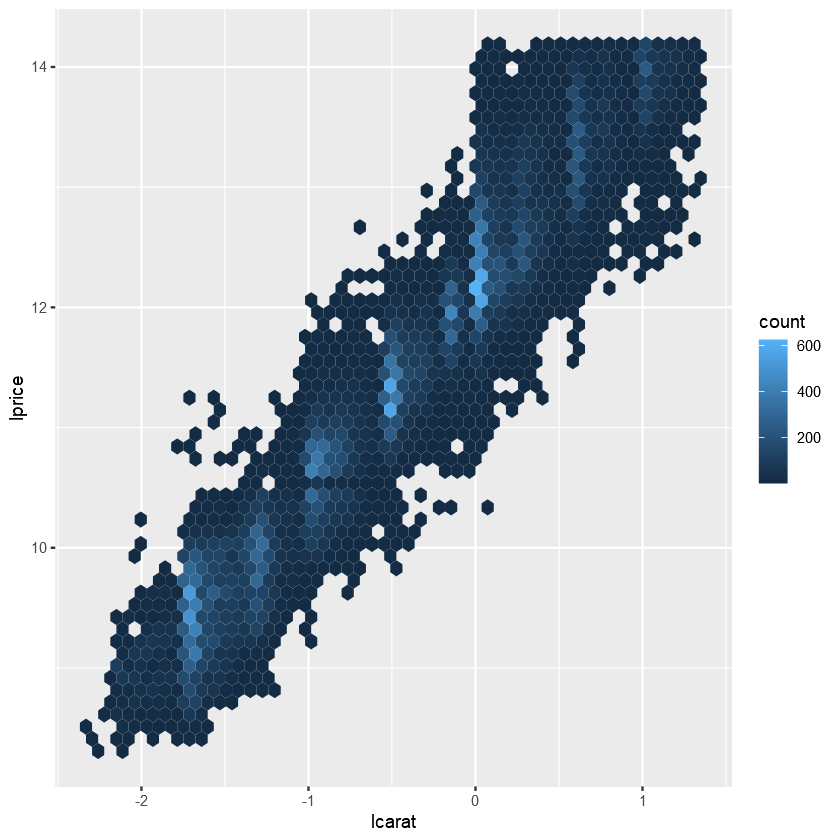

In [8]:
diamonds2 <- diamonds %>%
    filter(carat <= 2.5) %>% # 2.5캐럿보다 작은 다이아몬드로 한정
    mutate(lprice = log2(price), lcarat = log2(carat)) # 캐럿과 가격 변수를 로그 변환
ggplot(diamonds2, aes(lcarat, lprice)) + geom_hex(bins = 50)

#### carat과 price의 선형관계

In [9]:
(mod_diamond <- lm(lprice ~ lcarat, diamonds2))


Call:
lm(formula = lprice ~ lcarat, data = diamonds2)

Coefficients:
(Intercept)       lcarat  
     12.194        1.681  


In [11]:
grid <- diamonds %>%
    data_grid(carat = seq_range(carat, 20)) %>%
    mutate(lcarat = log(carat)) %>% 
    add_predictions(mod_diamond, "lprice") %>%
    mutate(price = 2 ^ lprice) # 예측값에 대해 로그 변환을 되돌리는 역변환
grid %>% print

# A tibble: 20 x 4
   carat  lcarat lprice  price
   <dbl>   <dbl>  <dbl>  <dbl>
 1 0.2   -1.61     9.49   718.
 2 0.453 -0.792   10.9   1863.
 3 0.706 -0.348   11.6   3124.
 4 0.959 -0.0414  12.1   4465.
 5 1.21   0.193   12.5   5865.
 6 1.47   0.382   12.8   7316.
 7 1.72   0.542   13.1   8809.
 8 1.97   0.679   13.3  10338.
 9 2.23   0.800   13.5  11901.
10 2.48   0.908   13.7  13493.
11 2.73   1.00    13.9  15112.
12 2.98   1.09    14.0  16757.
13 3.24   1.17    14.2  18425.
14 3.49   1.25    14.3  20114.
15 3.74   1.32    14.4  21824.
16 4.00   1.39    14.5  23553.
17 4.25   1.45    14.6  25301.
18 4.50   1.50    14.7  27065.
19 4.76   1.56    14.8  28846.
20 5.01   1.61    14.9  30643.


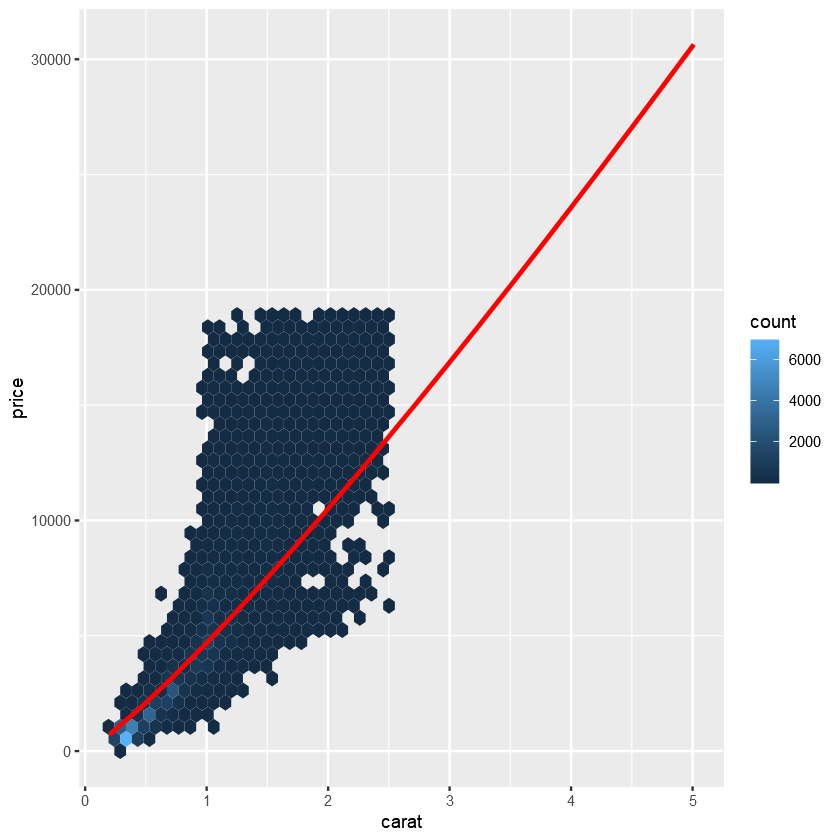

In [12]:
ggplot(diamonds2, aes(carat, price)) + 
    geom_hex(bins = 50) + 
    geom_line(data = grid, color = "red", size = 1)

# A tibble: 53,814 x 13
   carat cut     color clarity depth table price     x     y     z lprice lcarat
   <dbl> <ord>   <ord> <ord>   <dbl> <dbl> <int> <dbl> <dbl> <dbl>  <dbl>  <dbl>
 1  0.23 Ideal   E     SI2      61.5    55   326  3.95  3.98  2.43   8.35  -2.12
 2  0.21 Premium E     SI1      59.8    61   326  3.89  3.84  2.31   8.35  -2.25
 3  0.23 Good    E     VS1      56.9    65   327  4.05  4.07  2.31   8.35  -2.12
 4  0.29 Premium I     VS2      62.4    58   334  4.2   4.23  2.63   8.38  -1.79
 5  0.31 Good    J     SI2      63.3    58   335  4.34  4.35  2.75   8.39  -1.69
 6  0.24 Very G~ J     VVS2     62.8    57   336  3.94  3.96  2.48   8.39  -2.06
 7  0.24 Very G~ I     VVS1     62.3    57   336  3.95  3.98  2.47   8.39  -2.06
 8  0.26 Very G~ H     SI1      61.9    55   337  4.07  4.11  2.53   8.40  -1.94
 9  0.22 Fair    E     VS2      65.1    61   337  3.87  3.78  2.49   8.40  -2.18
10  0.23 Very G~ H     VS1      59.4    61   338  4     4.05  2.39   8.40  -2.12
# ..

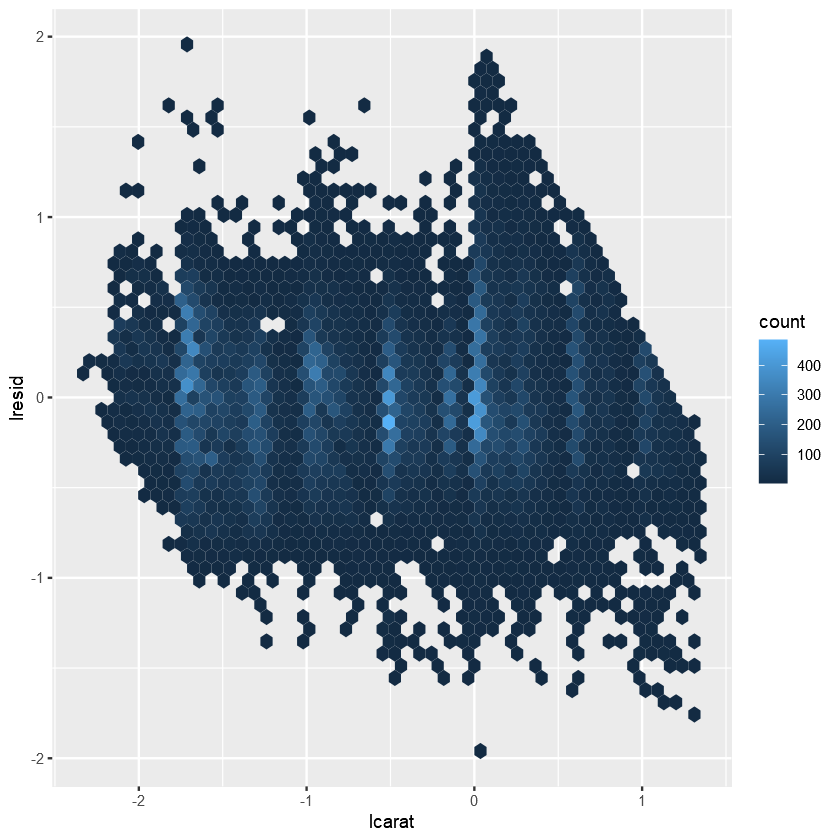

In [14]:
diamonds2 <- diamonds2 %>% 
    add_residuals(mod_diamond, "lresid")
diamonds2 %>% print

ggplot(diamonds2, aes(lcarat, lresid)) + 
    geom_hex(bins = 50)

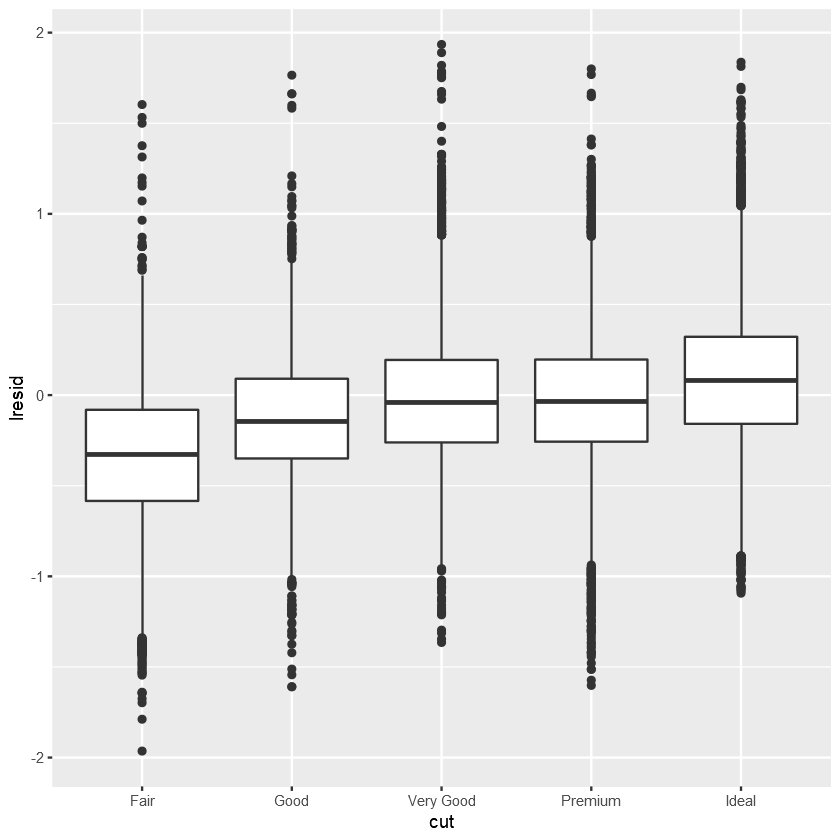

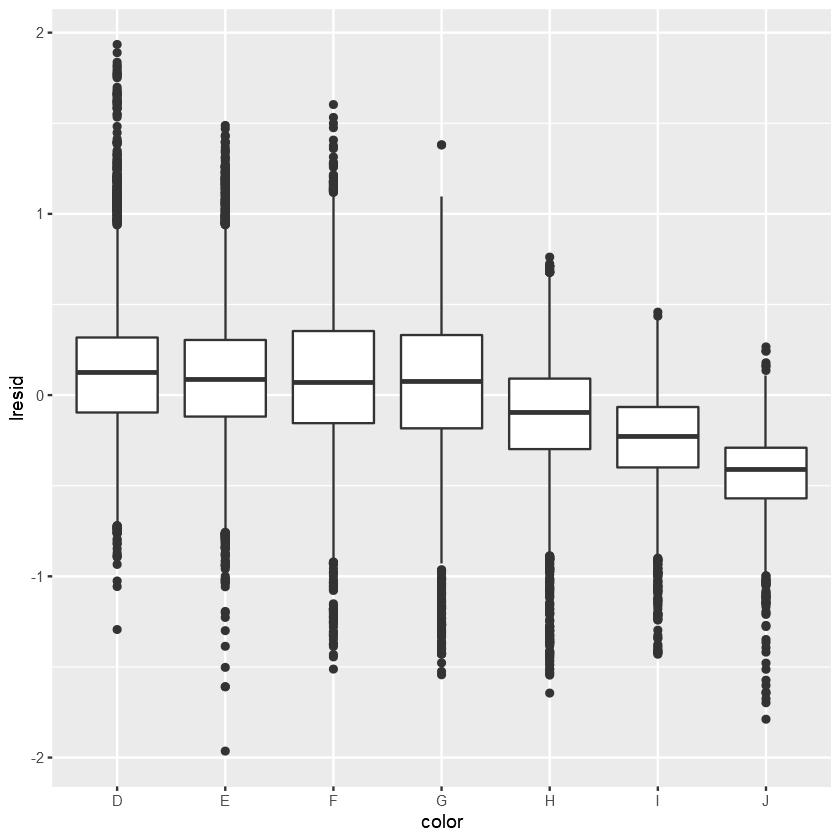

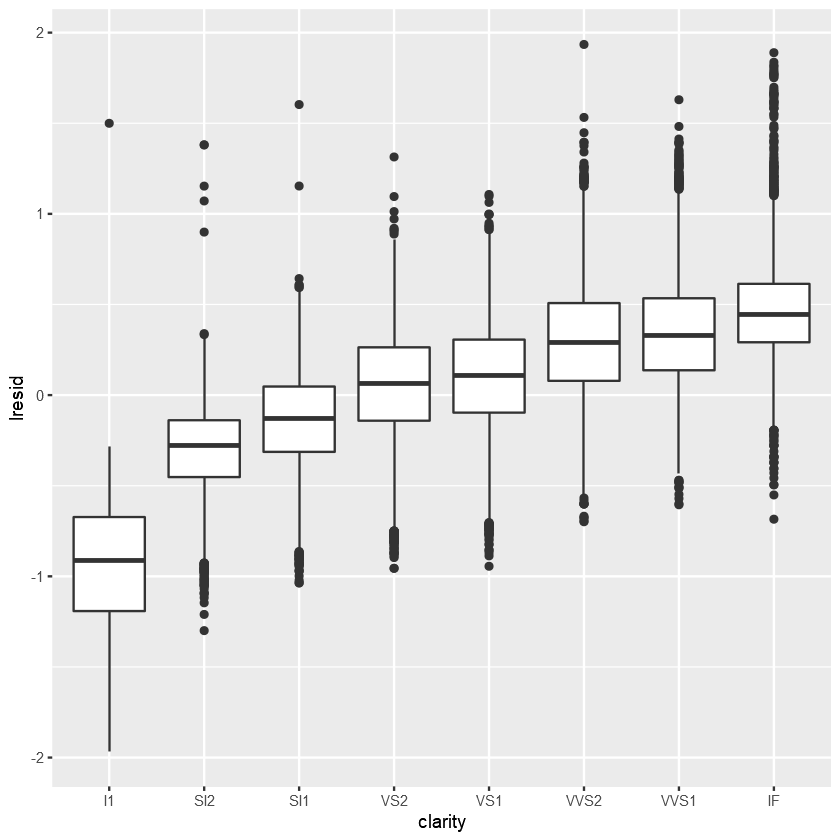

In [15]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()

#### 잔차가 -1이라는 것은 해당 변수만을 이용한 예측값보다 lprice가 한 단위 더 작다는 것을 의미
#### 2^-1은 1/2이므로 -1인 점은 예측한 가격의 절반에 해당하고, 잔차가 1인 점은 예측한 가격의 두 배를 나타냄

### 더 복잡한 모델

In [20]:
(mod_diamonds2 <- lm(lprice ~ lcarat + color + cut + clarity, diamonds2))


Call:
lm(formula = lprice ~ lcarat + color + cut + clarity, data = diamonds2)

Coefficients:
(Intercept)       lcarat      color.L      color.Q      color.C      color^4  
  12.206978     1.886239    -0.633998    -0.137580    -0.022072     0.016570  
    color^5      color^6        cut.L        cut.Q        cut.C        cut^4  
  -0.002828     0.003533     0.173866    -0.050346     0.019129    -0.002410  
  clarity.L    clarity.Q    clarity.C    clarity^4    clarity^5    clarity^6  
   1.308155    -0.334090     0.178423    -0.088059     0.035885    -0.001371  
  clarity^7  
   0.048221  


In [19]:
grid <- diamonds2 %>%
    data_grid(cut, .model = mod_diamonds2) %>%
    add_predictions(mod_diamonds2)
grid %>% print

# A tibble: 5 x 5
  cut       lcarat color clarity  pred
  <ord>      <dbl> <chr> <chr>   <dbl>
1 Fair      -0.515 G     VS2      11.2
2 Good      -0.515 G     VS2      11.3
3 Very Good -0.515 G     VS2      11.4
4 Premium   -0.515 G     VS2      11.4
5 Ideal     -0.515 G     VS2      11.4


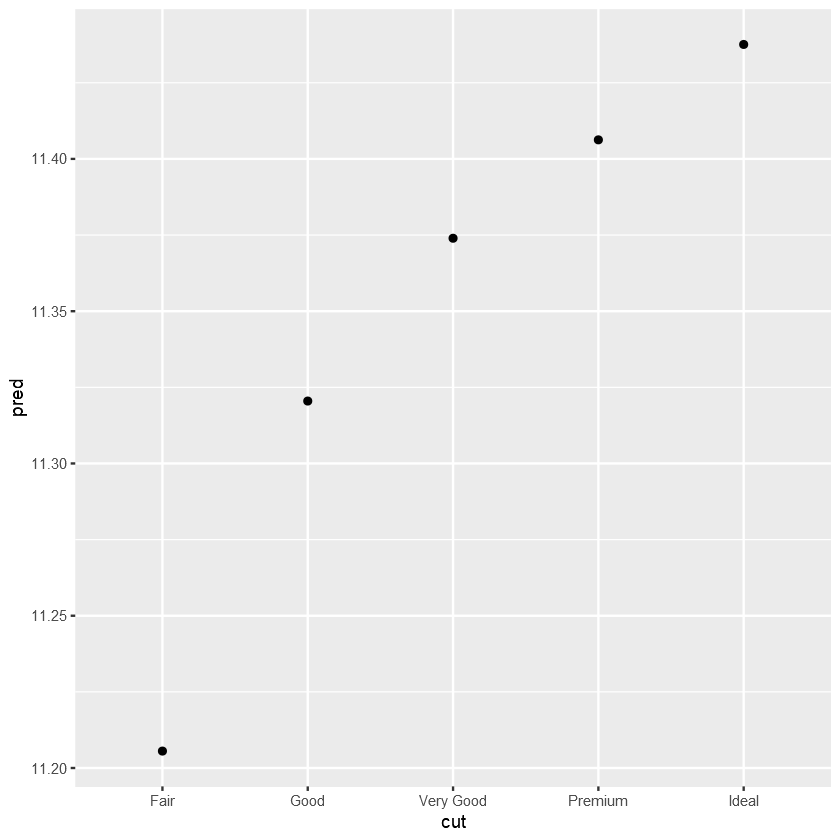

In [21]:
ggplot(grid, aes(cut, pred)) + 
    geom_point()

* 명시적으로 제공되지 않은 변수를 모델이 필요로 한다면 data_grid() 함수가 자동으로 '대표적인 값'으로 채울 것이다.
* 연속형 변수의 경우 중앙값을 사용, 범주형 변수의 경우 가장 빈번한 값을 사용

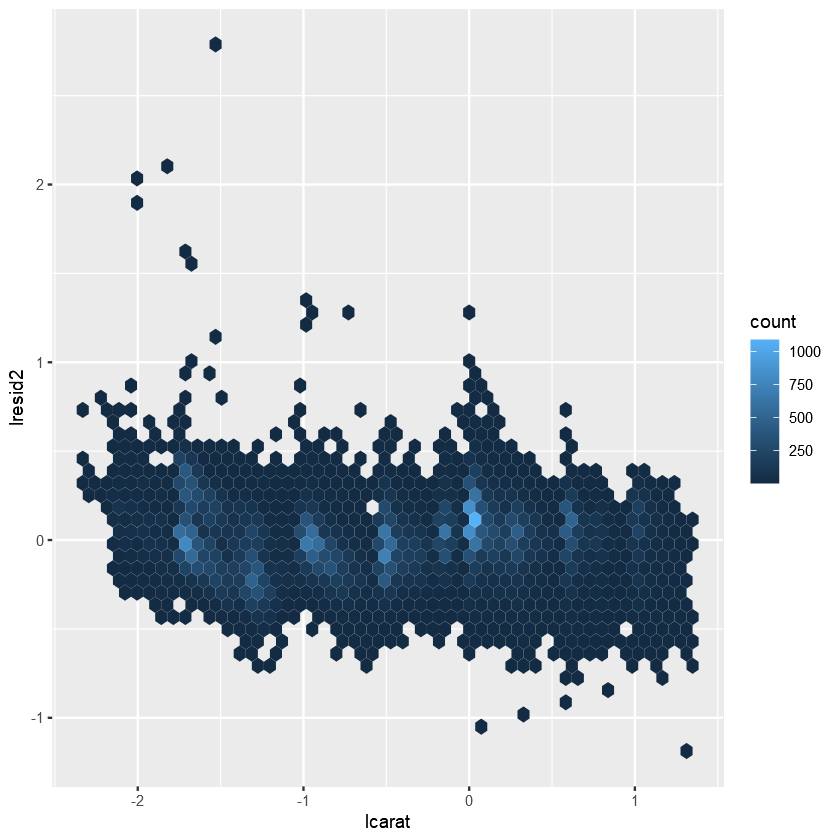

In [25]:
diamonds2 <- diamonds2 %>%
    add_residuals(mod_diamonds2, "lresid2")

ggplot(diamonds2, aes(lcarat, lresid2)) + 
    geom_hex(bins = 50)

* 잔차가 2라는 것은 다이아몬드의 가격이 예상했던 가격의 4배라는 것을 나타냄

In [31]:
diamonds2 %>%
    filter(abs(lresid2) > 1) %>%
    add_predictions(mod_diamonds2) %>%
    mutate(pred = round(2 ^ pred)) %>%
    select(price, pred, carat:table, x:z) %>%
    arrange(price)

price,pred,carat,cut,color,clarity,depth,table,x,y,z
<int>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1013,264,0.25,Fair,F,SI2,54.4,64,4.30,4.23,2.32
1186,284,0.25,Premium,G,SI2,59.0,60,5.33,5.28,3.12
1186,284,0.25,Premium,G,SI2,58.8,60,5.33,5.28,3.12
1262,2644,1.03,Fair,E,I1,78.2,54,5.72,5.59,4.42
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1715,576,0.32,Fair,F,VS2,59.6,60,4.42,4.34,2.61
1776,412,0.29,Fair,F,SI1,55.8,60,4.48,4.41,2.48
2160,314,0.34,Fair,F,I1,55.8,62,4.72,4.60,2.60


### 일일 운항 횟수에 어떤 영향이 있는가

In [32]:
daily <- flights %>%
    mutate(date = make_date(year, month, day)) %>%
    group_by(date) %>%
    summarize(n = n())
daily %>% print

# A tibble: 365 x 2
   date           n
   <date>     <int>
 1 2013-01-01   842
 2 2013-01-02   943
 3 2013-01-03   914
 4 2013-01-04   915
 5 2013-01-05   720
 6 2013-01-06   832
 7 2013-01-07   933
 8 2013-01-08   899
 9 2013-01-09   902
10 2013-01-10   932
# ... with 355 more rows


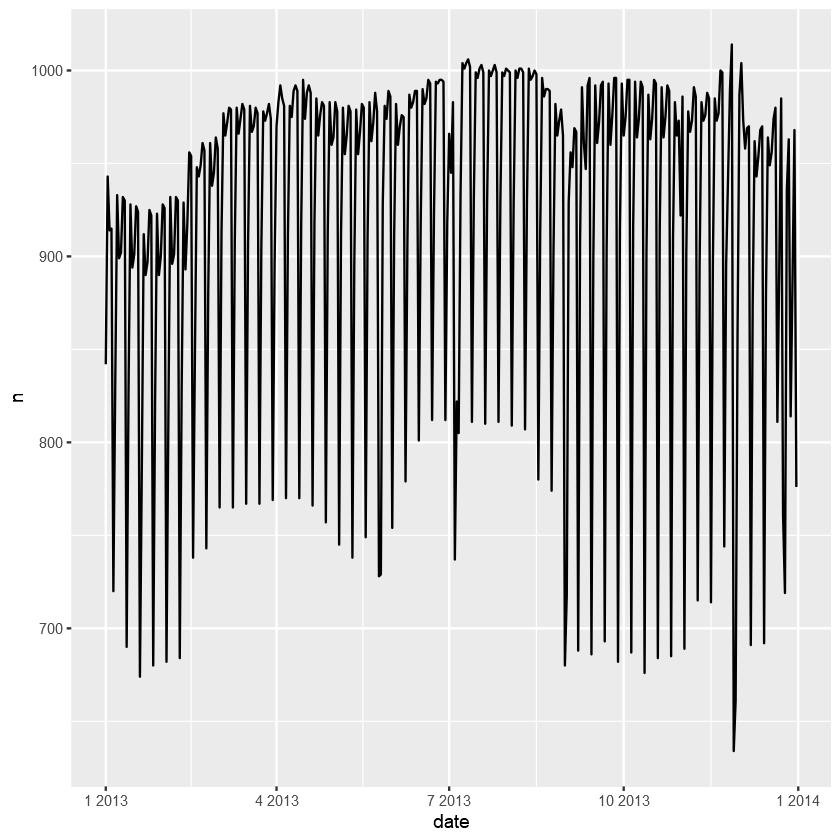

In [34]:
ggplot(daily, aes(date, n)) + geom_line()

#### 요일 효과가 매우 강하게 존재

In [35]:
daily <- daily %>%
    mutate(wday = wday(date, label = T))
daily$wday 

# A tibble: 365 x 3
   date           n wday 
   <date>     <int> <ord>
 1 2013-01-01   842 화   
 2 2013-01-02   943 수   
 3 2013-01-03   914 목   
 4 2013-01-04   915 금   
 5 2013-01-05   720 토   
 6 2013-01-06   832 일   
 7 2013-01-07   933 월   
 8 2013-01-08   899 화   
 9 2013-01-09   902 수   
10 2013-01-10   932 목   
# ... with 355 more rows


In [ ]:
library(showtext)
font_add("nanum", "NanumGothic.ttf")
showtext_auto()

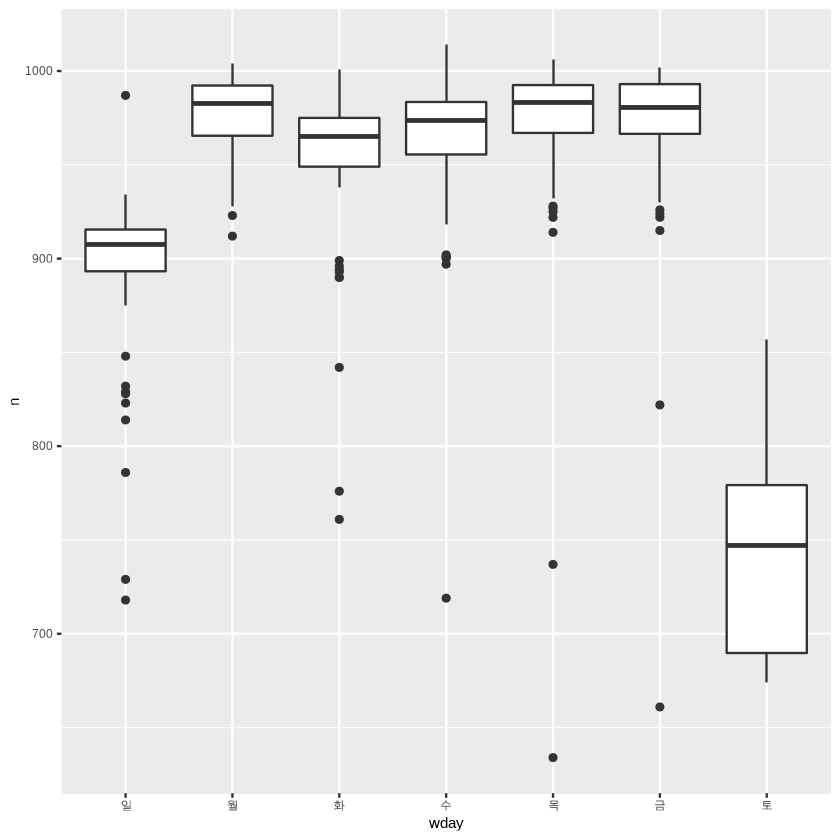

In [39]:
ggplot(daily, aes(wday, n)) + geom_boxplot()

#### 주말에는 항공편의 수가 적다.

In [41]:
mod <- lm(n ~ wday, daily)

grid <- daily %>%
    data_grid(wday) %>%
    add_predictions(mod, "n")
grid %>% print

# A tibble: 7 x 2
  wday      n
  <ord> <dbl>
1 일     891.
2 월     975.
3 화     951.
4 수     963.
5 목     966.
6 금     967.
7 토     745.


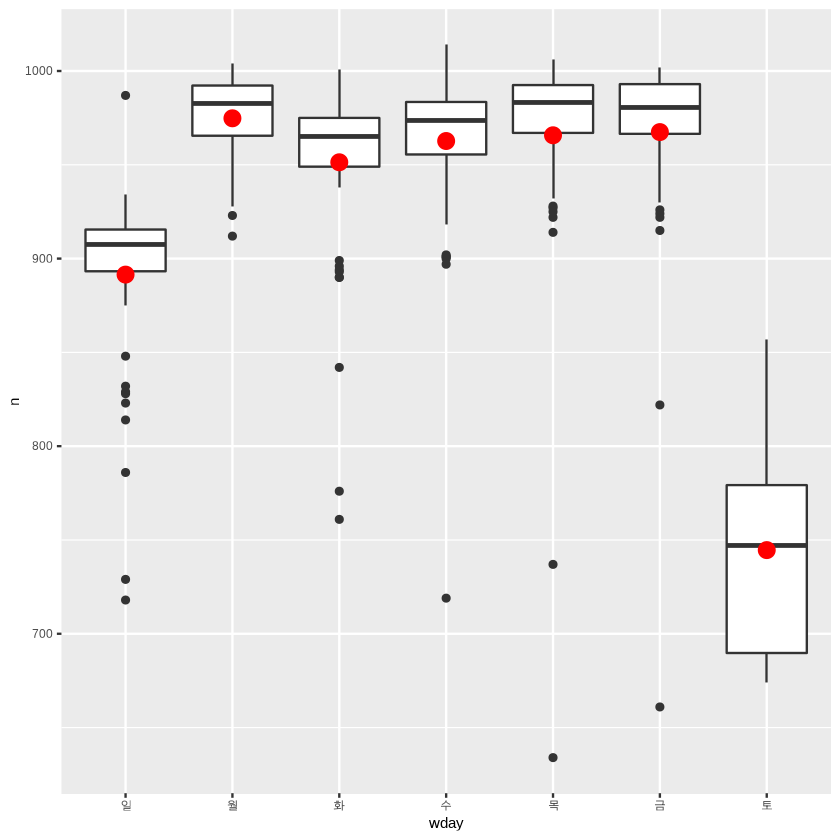

In [42]:
ggplot(daily, aes(wday, n)) + 
    geom_boxplot() + 
    geom_point(data = grid, color = "red", size = 4)

#### 잔차를 계산 후 시각화

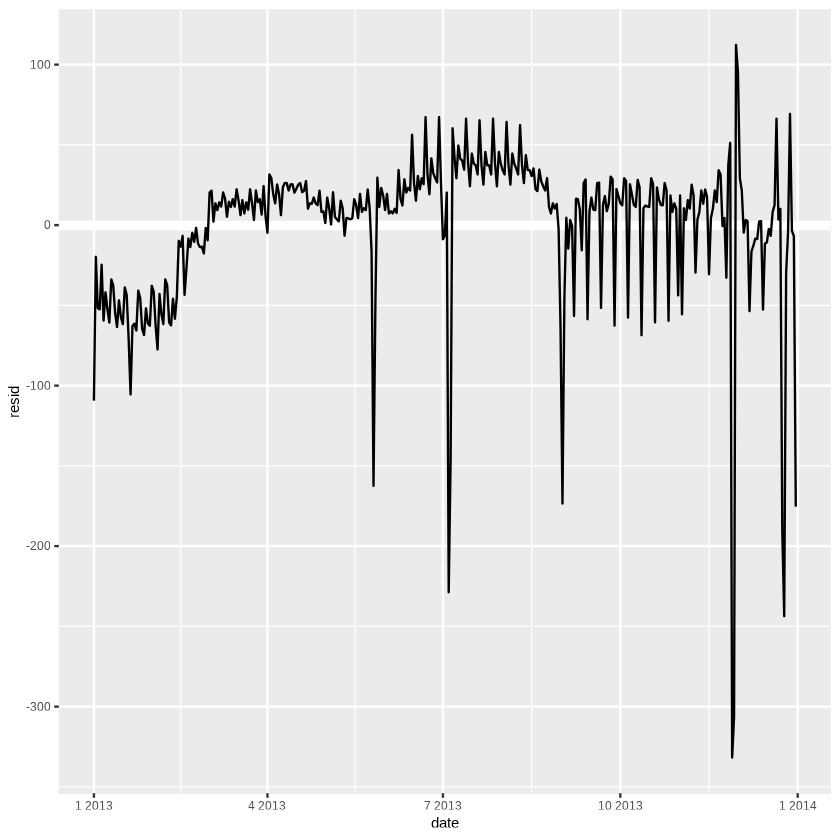

In [43]:
daily <- daily %>%
    add_residuals(mod)
daily %>% ggplot(aes(date, resid)) + 
    geom_ref_line(h = 0) + 
    geom_line()

#### 6월부터 잔차가 증가 => 6월부터 모델이 잘 맞지 않음, 여전히 모델이 포착하지 못한 규칙적이고 강한 패턴을 확인

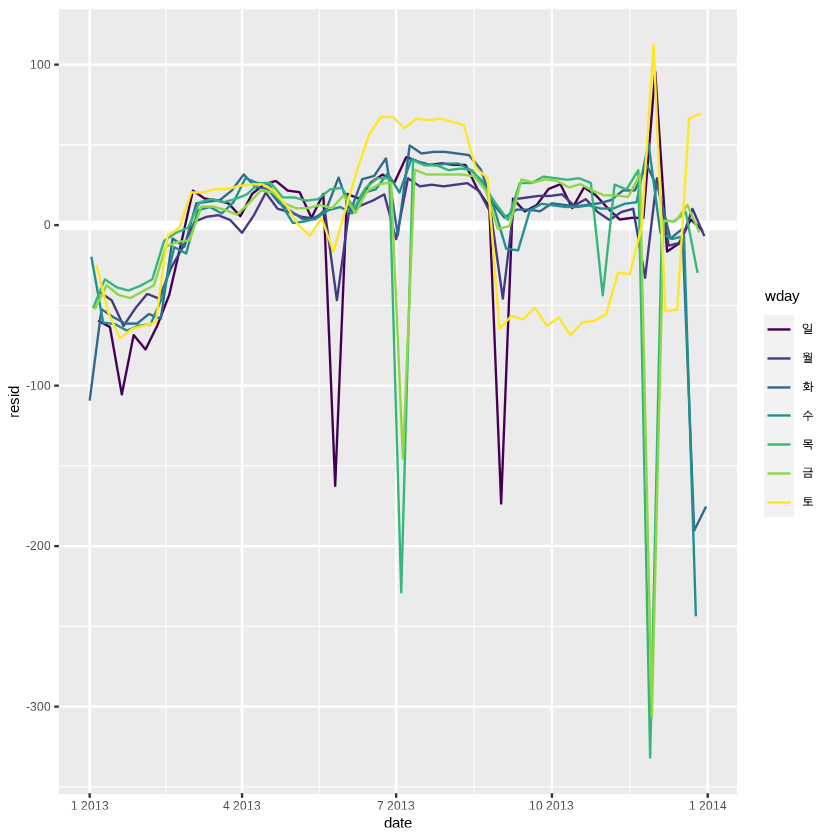

In [44]:
ggplot(daily, aes(date, resid, color = wday)) + 
    geom_ref_line(h = 0) + 
    geom_line()

* 이 모형은 토요일의 비행 횟수를 정확하게 예측하지 못함
* 여름에는 예측한 값보다 많은 항공편이 있고, 가을에는 더 적은 항공편이 있다.

In [47]:
daily %>% 
    filter(resid < 100) %>% print

# A tibble: 364 x 4
   date           n wday   resid
   <date>     <int> <ord>  <dbl>
 1 2013-01-01   842 화    -109. 
 2 2013-01-02   943 수     -19.7
 3 2013-01-03   914 목     -51.8
 4 2013-01-04   915 금     -52.5
 5 2013-01-05   720 토     -24.6
 6 2013-01-06   832 일     -59.5
 7 2013-01-07   933 월     -41.8
 8 2013-01-08   899 화     -52.4
 9 2013-01-09   902 수     -60.7
10 2013-01-10   932 목     -33.8
# ... with 354 more rows


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



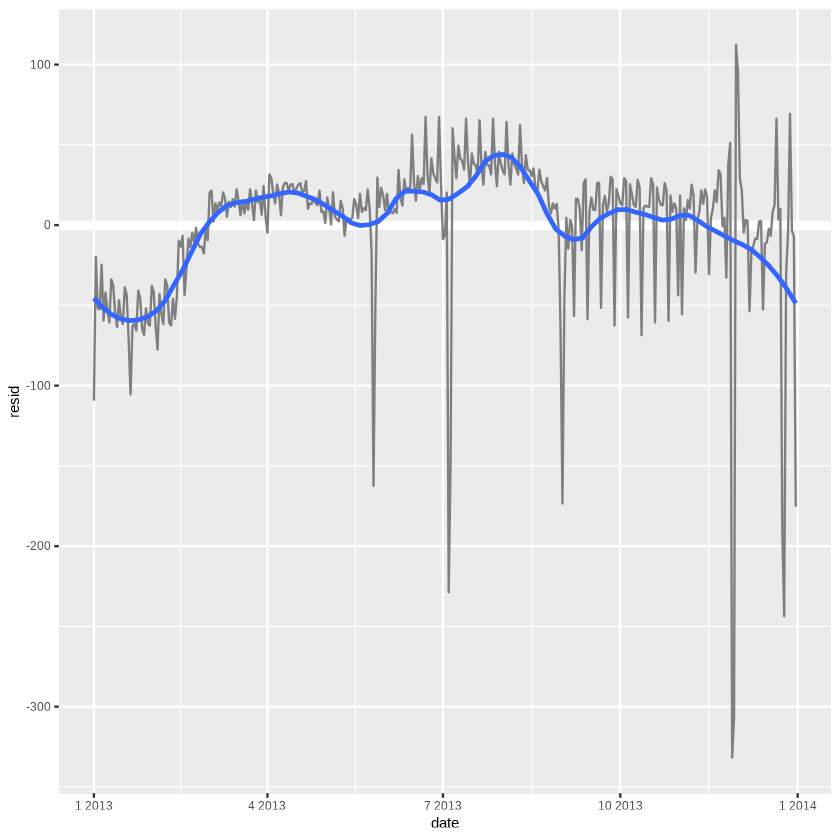

In [48]:
daily %>%
    ggplot(aes(date, resid)) +
    geom_ref_line(h = 0) + 
    geom_line(color = "grey50") +
    geom_smooth(se = F, span = 0.2)

### 주기적인 토요일 효과

#### 토요일로 한정한 데이터

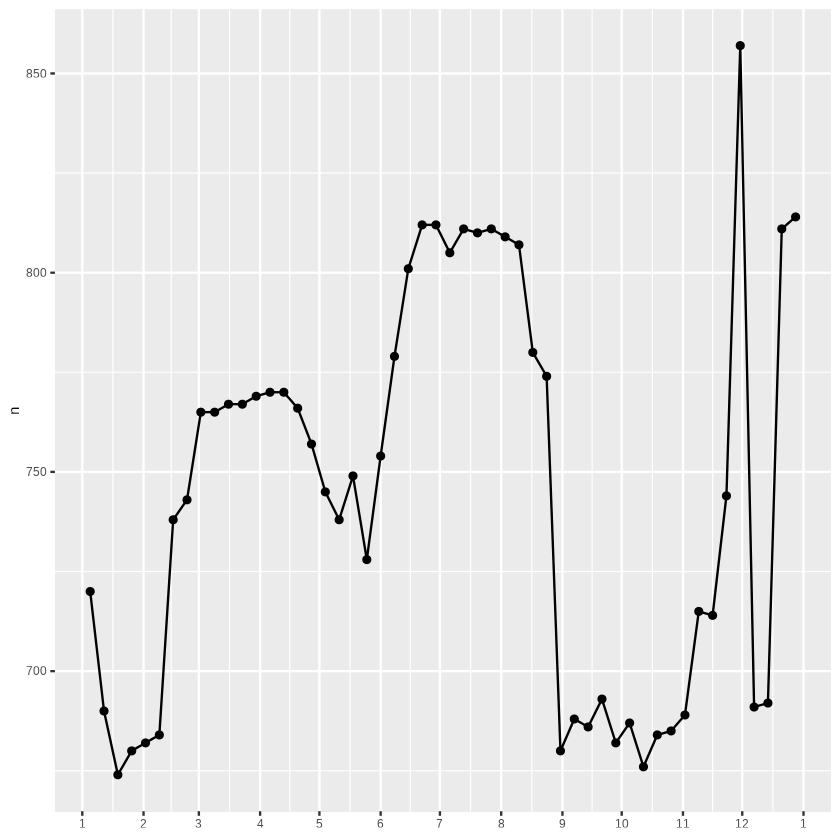

In [57]:
daily %>%
    filter(wday == "토") %>%
    ggplot(aes(date, n)) + 
    geom_point() +
    geom_line() + 
    scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")

* 여름 휴가로 인한 여름 비행 횟수 증가

#### 대략 세 개의 학기를 포함하는 학기(term)변수를 만들고 그래프로 확인

- 20130101 ~ 20130605 : spring
- 20130605 ~ 201300825 : summer
- 20130825 ~ 20140101 : fall

In [59]:
term <- function(date) {
    cut(date,
       breaks = ymd(20130101, 20130605, 20130825, 20140101),
       labels = c("spring", "summer", "fall")
       )
}

daily <- daily %>%
    mutate(term = term(date))
daily %>% print

# A tibble: 365 x 5
   date           n wday   resid term  
   <date>     <int> <ord>  <dbl> <fct> 
 1 2013-01-01   842 화    -109.  spring
 2 2013-01-02   943 수     -19.7 spring
 3 2013-01-03   914 목     -51.8 spring
 4 2013-01-04   915 금     -52.5 spring
 5 2013-01-05   720 토     -24.6 spring
 6 2013-01-06   832 일     -59.5 spring
 7 2013-01-07   933 월     -41.8 spring
 8 2013-01-08   899 화     -52.4 spring
 9 2013-01-09   902 수     -60.7 spring
10 2013-01-10   932 목     -33.8 spring
# ... with 355 more rows


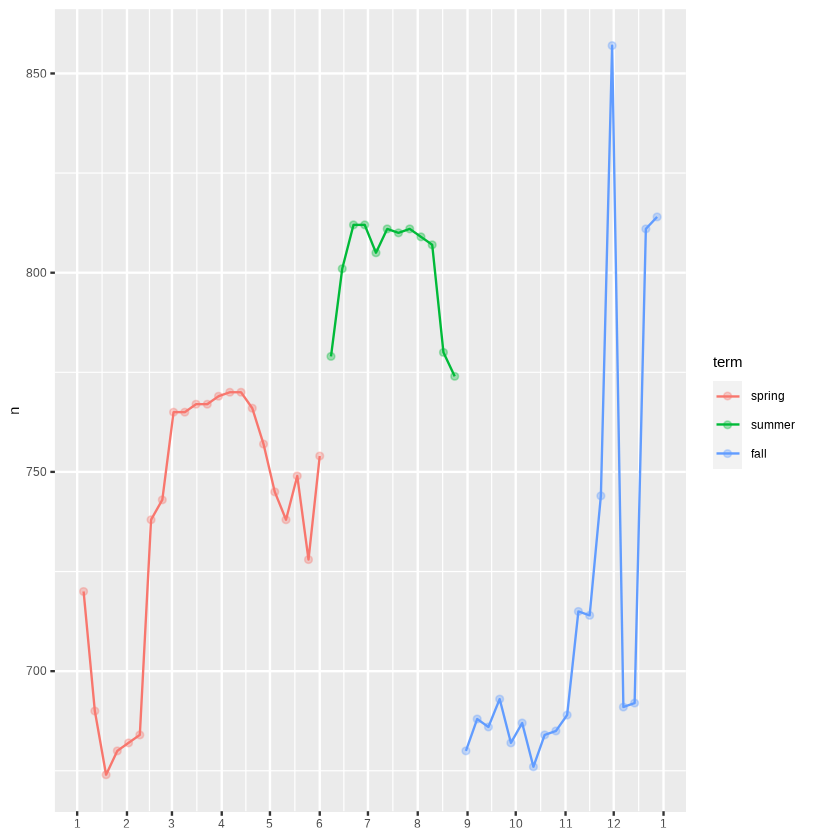

In [60]:
daily %>% 
    filter(wday == "토") %>%
    ggplot(aes(date, n, color = term)) + 
    geom_point(alpha = 1/3) +
    geom_line() + 
    scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")

#### 새로운 변수가 다른 요일에 어떤 영향을 미치는지 확인

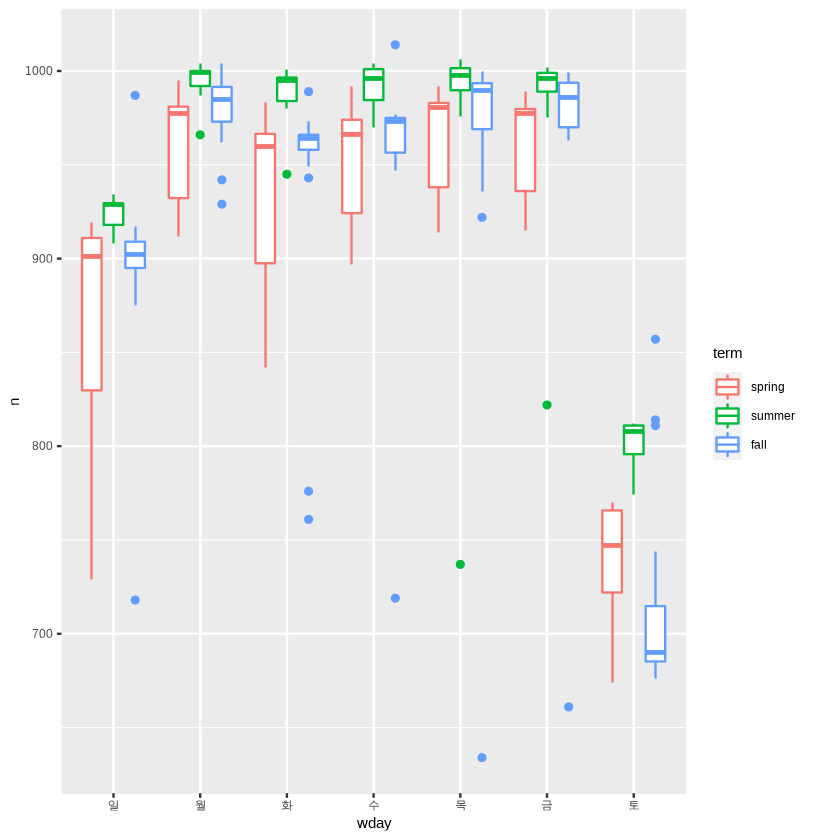

In [61]:
daily %>%
    ggplot(aes(wday, n, color = term)) + 
    geom_boxplot()

#### 학기 전반에 걸쳐 상당한 변동이 있는 것 처럼 보임
#### 각 학기에 대해 별도의 요일 효과를 적용하는 것이 합리적
#### 요일 효과는 모델을 개선하기는 하지만 기대할 수 있는 만큼은 아니다

In [65]:
mod1 <- lm(n ~ wday, daily) # 요일효과 미포함 (with_term)
mod2 <- lm(n ~ wday * term, data = daily) # 요일효과 포함 (without_term)

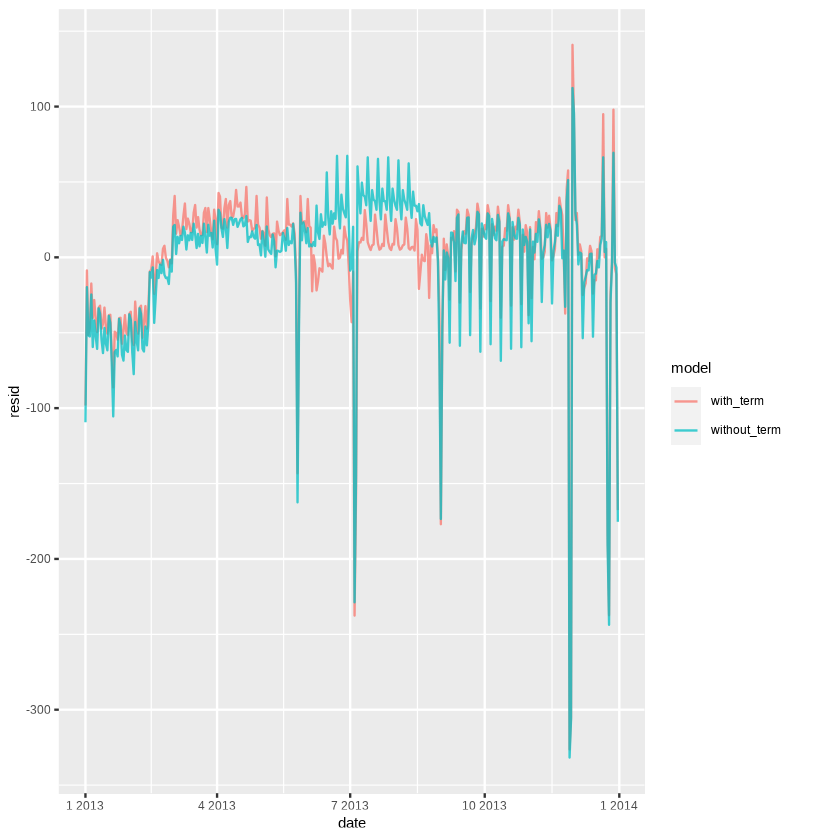

In [66]:
daily %>% 
    gather_residuals(without_term = mod1, with_term = mod2) %>%
    ggplot(aes(date, resid, color = model)) + 
    geom_line(alpha = 0.75)

In [69]:
grid <- daily %>%
    data_grid(wday, term) %>%
    add_predictions(mod2, "n")
grid %>% print

# A tibble: 21 x 3
   wday  term       n
   <ord> <fct>  <dbl>
 1 일    spring  872.
 2 일    summer  924.
 3 일    fall    895 
 4 월    spring  961.
 5 월    summer  994.
 6 월    fall    979.
 7 화    spring  940.
 8 화    summer  988 
 9 화    fall    944.
10 수    spring  952.
# ... with 11 more rows


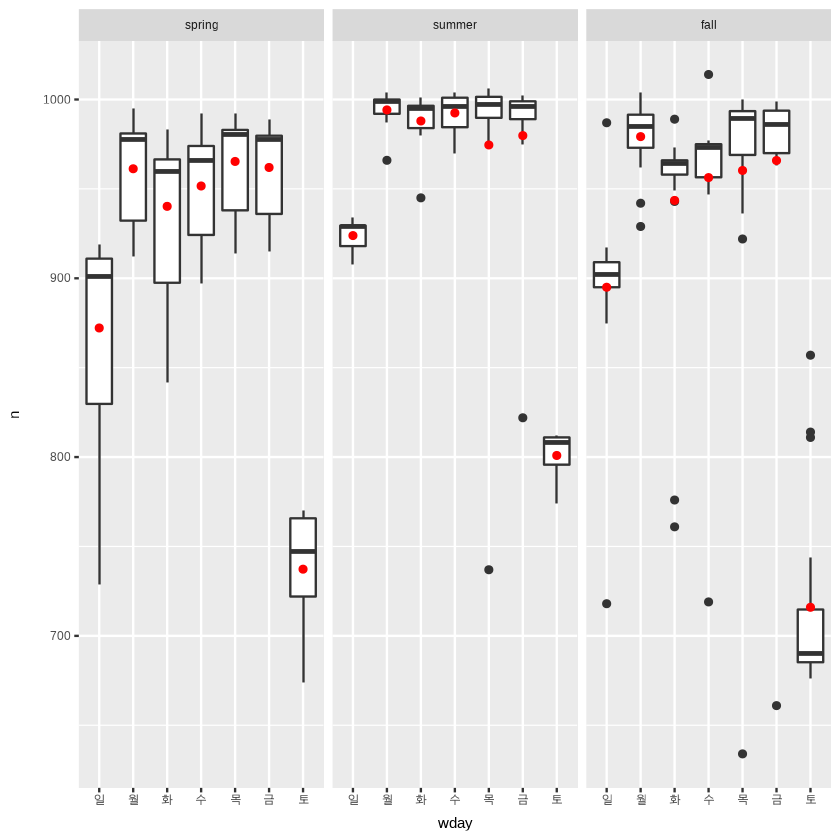

In [70]:
ggplot(daily, aes(wday, n)) + 
    geom_boxplot() + 
    geom_point(data = grid, color = "red") + 
    facet_wrap(~ term)

#### 모델은 평균 효과를 찾지만, 값이 큰 이상값들이 많으므로 평균값은 일반적인 값과 멀어지는 경향이 있다
#### 이 문제는 이상값에 영향을 덜 받는 robust 모델을 사용
### MASS:rlm() : 로버스트 회귀, 이상값이 추정값에 미치는 영향을 줄이고, 요일 패턴을 제거
- 장기적인 추세와 양과 음의 이상값을 훨씬 쉽게 확인 가능

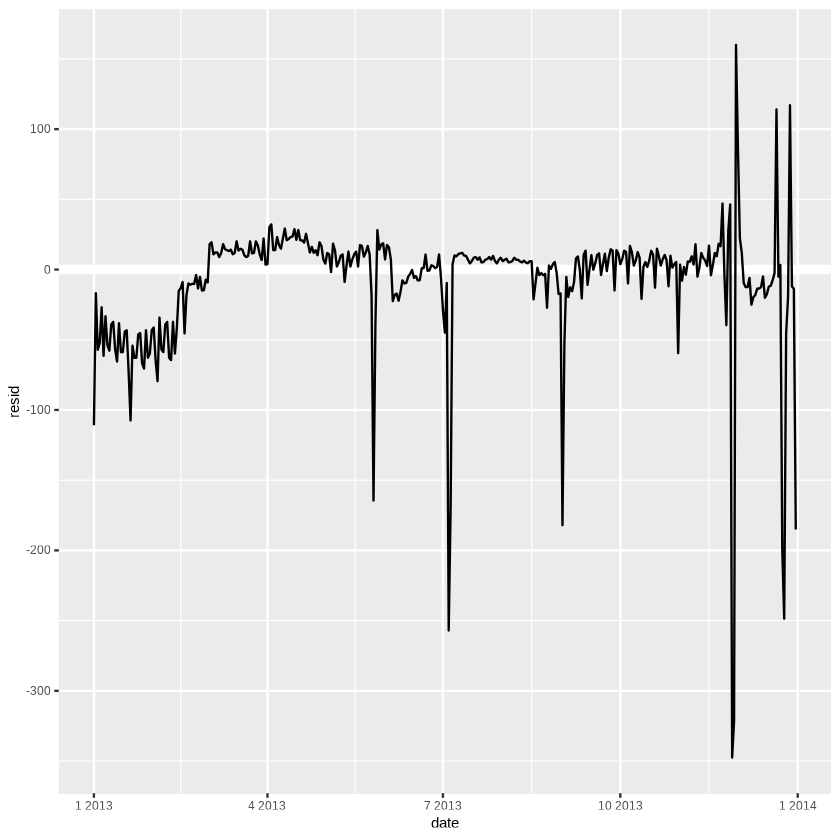

In [72]:
mod3 <- MASS::rlm(n ~ wday * term, data = daily)

daily %>% 
    add_residuals(mod3, "resid") %>%
    ggplot(aes(date, resid)) + 
    geom_hline(yintercept = 0, size = 2, color = "white") + 
    geom_line()

### 계산된 변수

In [74]:
compute_vars <- function(data) {
    data %>% 
        mutate(
            term = term(date),
            wday = wday(date, label = T)
        )
}

wday2 <- function(x) wday(x, label = T)
mod3 <- lm(n ~ wday2(date) * term(date), daily)

### 연중 시각 : 다른 접근법

#### 더 유연한 모델을 사용하여 관심 있는 패턴을 포착
#### 간단한 선형 추세는 부적합 => 1년의 기간에 대해서 매끄러운 스플라인 회귀

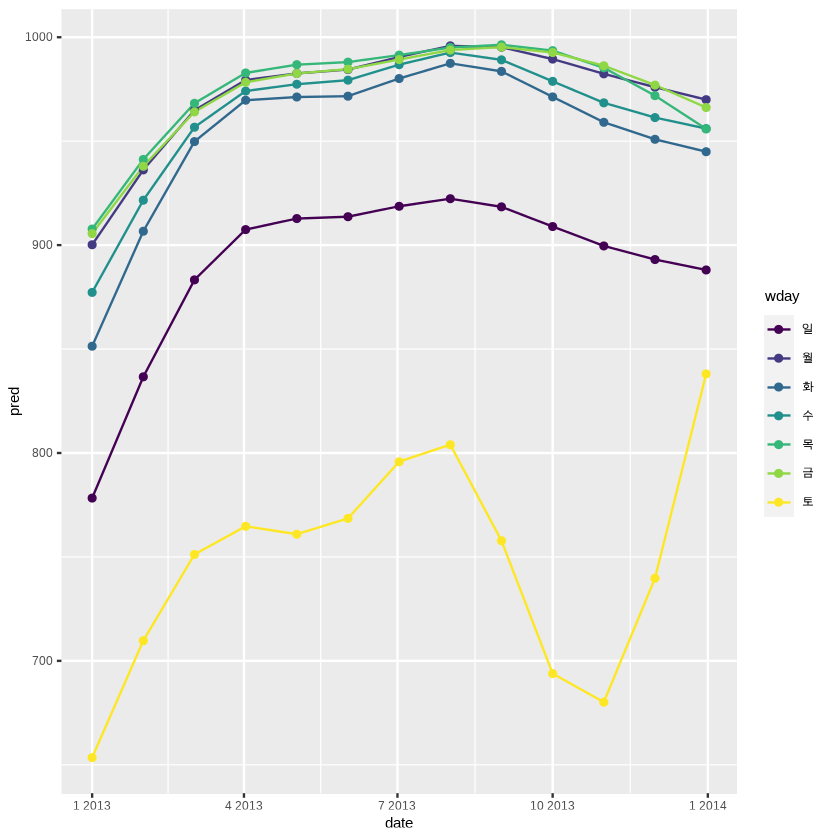

In [75]:
library(splines)
mod <- MASS::rlm(n ~ wday * ns(date, 5), daily)

daily %>%
    data_grid(wday, date = seq_range(date, n = 13)) %>%
    add_predictions(mod) %>%
    ggplot(aes(date, pred, color = wday)) +
        geom_line() + geom_point()

In [77]:
# 19.3.5
# 2
daily %>% top_n(3, resid)

date,n,wday,resid,term
<date>,<int>,<ord>,<dbl>,<fct>
2013-11-30,857,토,112.38462,fall
2013-12-01,987,일,95.51923,fall
2013-12-28,814,토,69.38462,fall


상위 3일은 추수감사절 다음 토요일(11월 30일), 추수감사절 다음 일요일(12월 1일), 크리스마스 다음 토요일(12월 28일)에 해당

In [79]:
# 3
daily <- daily %>%
  mutate(
    wday2 =
      case_when(
        wday == "토" & term == "summer" ~ "토-summer",
        wday == "토" & term == "fall" ~ "토-fall",
        wday == "토" & term == "spring" ~ "토-spring",
        TRUE ~ as.character(wday)
      )
  )
daily %>% print

# A tibble: 365 x 6
   date           n wday   resid term   wday2    
   <date>     <int> <ord>  <dbl> <fct>  <chr>    
 1 2013-01-01   842 화    -109.  spring 화       
 2 2013-01-02   943 수     -19.7 spring 수       
 3 2013-01-03   914 목     -51.8 spring 목       
 4 2013-01-04   915 금     -52.5 spring 금       
 5 2013-01-05   720 토     -24.6 spring 토-spring
 6 2013-01-06   832 일     -59.5 spring 일       
 7 2013-01-07   933 월     -41.8 spring 월       
 8 2013-01-08   899 화     -52.4 spring 화       
 9 2013-01-09   902 수     -60.7 spring 수       
10 2013-01-10   932 목     -33.8 spring 목       
# ... with 355 more rows


In [91]:
mod3 <- lm(n ~ wday2, daily)
mod2 <- lm(n ~ wday * term, data = daily) # 요일효과 포함 (without_term)

In [92]:
daily3 <- daily %>%
      gather_residuals(sat_term = mod3, all_interact = mod2) %>% print

# A tibble: 730 x 7
   model    date           n wday   resid term   wday2    
   <chr>    <date>     <int> <ord>  <dbl> <fct>  <chr>    
 1 sat_term 2013-01-01   842 화    -109.  spring 화       
 2 sat_term 2013-01-02   943 수     -19.7 spring 수       
 3 sat_term 2013-01-03   914 목     -51.7 spring 목       
 4 sat_term 2013-01-04   915 금     -52.5 spring 금       
 5 sat_term 2013-01-05   720 토     -17.3 spring 토-spring
 6 sat_term 2013-01-06   832 일     -59.5 spring 일       
 7 sat_term 2013-01-07   933 월     -41.8 spring 월       
 8 sat_term 2013-01-08   899 화     -52.4 spring 화       
 9 sat_term 2013-01-09   902 수     -60.7 spring 수       
10 sat_term 2013-01-10   932 목     -33.7 spring 목       
# ... with 720 more rows


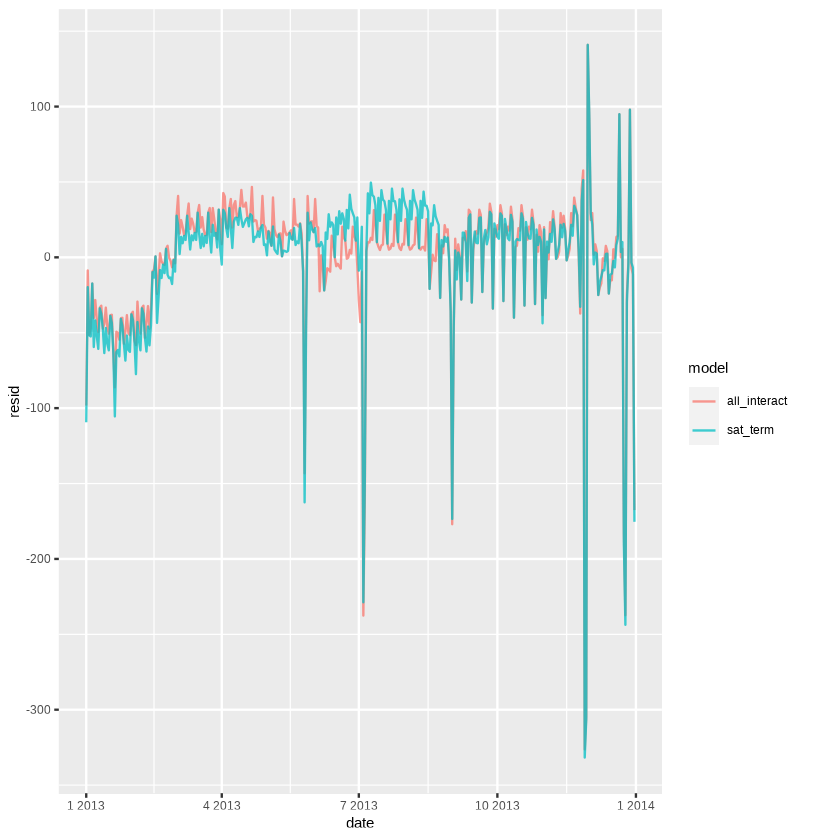

In [93]:
ggplot(daily3, aes(date, resid, colour = model)) +
  geom_line(alpha = 0.75)

이 코드에서는 각 모델에 대해 새 행을 생성하는 gather_residuals() 대신 spread_residuals()를 사용하여 모델당 하나의 열을 추가.

In [96]:
daily4 <- daily %>%
      spread_residuals(sat_term = mod3, all_interact = mod2)
daily4 %>% print

# A tibble: 365 x 8
   date           n wday   resid term   wday2     sat_term all_interact
   <date>     <int> <ord>  <dbl> <fct>  <chr>        <dbl>        <dbl>
 1 2013-01-01   842 화    -109.  spring 화          -109.        -98.3 
 2 2013-01-02   943 수     -19.7 spring 수           -19.7        -8.64
 3 2013-01-03   914 목     -51.8 spring 목           -51.7       -51.4 
 4 2013-01-04   915 금     -52.5 spring 금           -52.5       -47.0 
 5 2013-01-05   720 토     -24.6 spring 토-spring    -17.3       -17.3 
 6 2013-01-06   832 일     -59.5 spring 일           -59.5       -40.2 
 7 2013-01-07   933 월     -41.8 spring 월           -41.8       -28.3 
 8 2013-01-08   899 화     -52.4 spring 화           -52.4       -41.3 
 9 2013-01-09   902 수     -60.7 spring 수           -60.7       -49.6 
10 2013-01-10   932 목     -33.8 spring 목           -33.7       -33.4 
# ... with 355 more rows


#### mod3과 mod2모형의 잔차의 차이

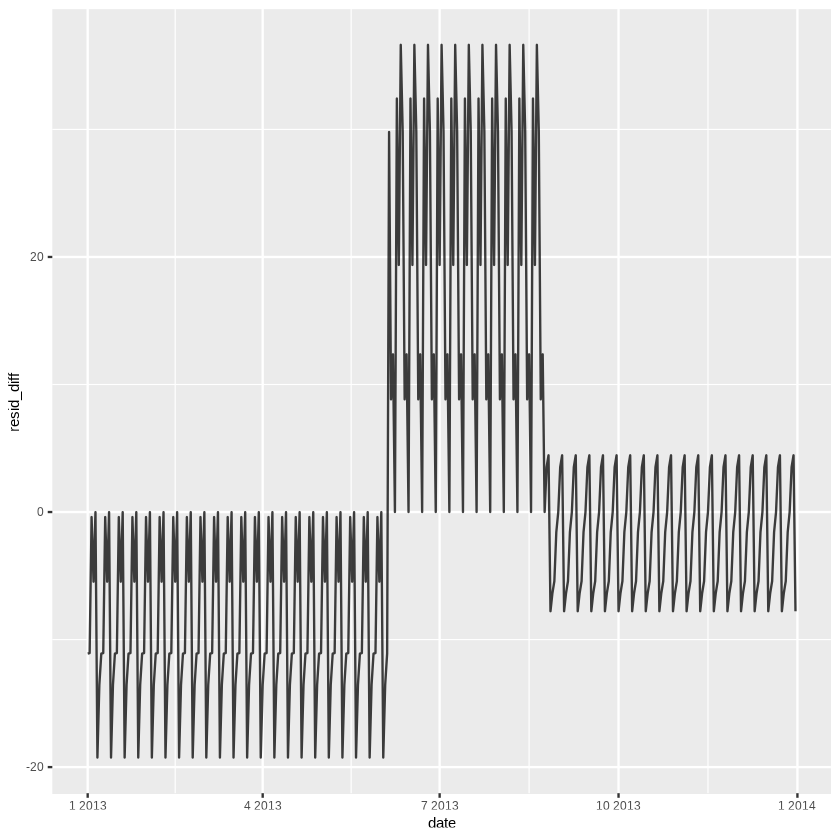

In [97]:
daily4 %>%  
    mutate(resid_diff = sat_term - all_interact) %>%
    ggplot(aes(date, resid_diff)) +
    geom_line(alpha = 0.75)

In [106]:
library(broom)
glance(mod3) %>% select(r.squared, sigma, AIC, df) # n ~ wday2
glance(mod2) %>% select(r.squared, sigma, AIC, df) # n ~ wday * term

r.squared,sigma,AIC,df
<dbl>,<dbl>,<dbl>,<dbl>
0.7356615,47.35969,3862.885,8


r.squared,sigma,AIC,df
<dbl>,<dbl>,<dbl>,<dbl>
0.757289,46.16568,3855.73,20


In [108]:
# 4
holidays_2013 <-
  tribble(
    ~holiday, ~date,
    "New Year's Day", 20130101,
    "Martin Luther King Jr. Day", 20130121,
    "Washington's Birthday", 20130218,
    "Memorial Day", 20130527,
    "Independence Day", 20130704,
    "Labor Day", 20130902,
    "Columbus Day", 20131028,
    "Veteran's Day", 20131111,
    "Thanksgiving", 20131128,
    "Christmas", 20131225
  ) %>%
  mutate(date = lubridate::ymd(date))
holidays_2013 %>% print

# A tibble: 10 x 2
   holiday                    date      
   <chr>                      <date>    
 1 New Year's Day             2013-01-01
 2 Martin Luther King Jr. Day 2013-01-21
 3 Washington's Birthday      2013-02-18
 4 Memorial Day               2013-05-27
 5 Independence Day           2013-07-04
 6 Labor Day                  2013-09-02
 7 Columbus Day               2013-10-28
 8 Veteran's Day              2013-11-11
 9 Thanksgiving               2013-11-28
10 Christmas                  2013-12-25


#### 요일, 학기 및 공휴일을 결합한 새로운 변수 wday

In [109]:
daily <- daily %>%
  mutate(
    wday3 =
      case_when(
        date %in% (holidays_2013$date - 1L) ~ "day before holiday",
        date %in% (holidays_2013$date + 1L) ~ "day after holiday",
        date %in% holidays_2013$date ~ "holiday",
        .$wday == "Sat" & .$term == "summer" ~ "Sat-summer",
        .$wday == "Sat" & .$term == "fall" ~ "Sat-fall",
        .$wday == "Sat" & .$term == "spring" ~ "Sat-spring",
        TRUE ~ as.character(.$wday)
      )
  )

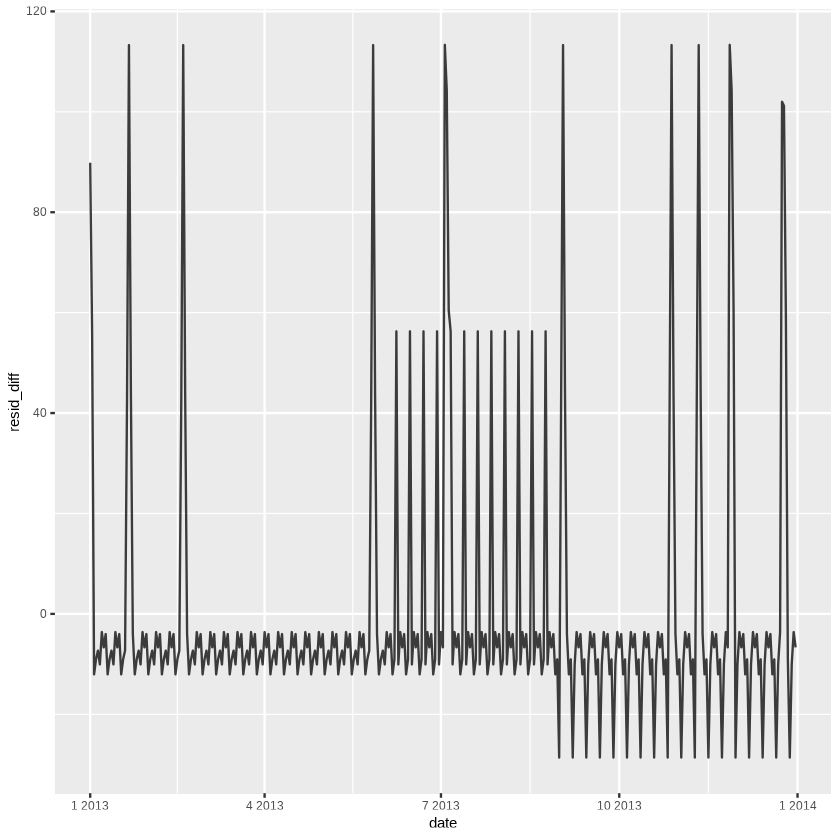

In [110]:
mod4 <- lm(n ~ wday3, data = daily)

daily %>%
  spread_residuals(resid_sat_terms = mod3, resid_holidays = mod4) %>%
  mutate(resid_diff = resid_holidays - resid_sat_terms) %>%
  ggplot(aes(date, resid_diff)) +
  geom_line(alpha = 0.75)

In [113]:
# 5
daily <- mutate(daily, month = factor(lubridate::month(date)))
(mod6 <- lm(n ~ wday * month, data = daily))


Call:
lm(formula = n ~ wday * month, data = daily)

Coefficients:
   (Intercept)          wday.L          wday.Q          wday.C          wday^4  
      867.4000        -64.0744       -165.6001        -68.2591        -92.0814  
        wday^5          wday^6          month2          month3          month4  
        9.7925        -20.4376         23.7071         67.8857         74.5929  
        month5          month6          month7          month8          month9  
       56.2786         80.3071         77.1143         81.6357         51.3714  
       month10         month11         month12   wday.L:month2   wday.Q:month2  
       60.1357         46.9143         38.7786         -3.7230         -3.8188  
 wday.C:month2   wday^4:month2   wday^5:month2   wday^6:month2   wday.L:month3  
        0.4899          4.5690         -4.2552         12.0570        -14.5705  
 wday.Q:month3   wday.C:month3   wday^4:month3   wday^5:month3   wday^6:month3  
       15.4389          8.2262         22.

- 월별로 달라지는 요일 효과를 맞추면 모델에 12 * 7 = 84개의 매개변수가 존재. 
- 각 달에는 4 ~ 5주가 있으므로 이러한 요일  00월 효과는 각각 4 ~ 5개 관찰의 평균
- 이러한 추정값은 표준 오차가 크며 표본 데이터 이상으로 일반화되지 않을 수 있음. 
- 이는 소수의 관측값에서만 추정되기 때문

In [114]:
# 7
mod7 <- lm(n ~ wday + ns(date, 5), data = daily)
mod8 <- lm(n ~ wday * ns(date, 5), data = daily)

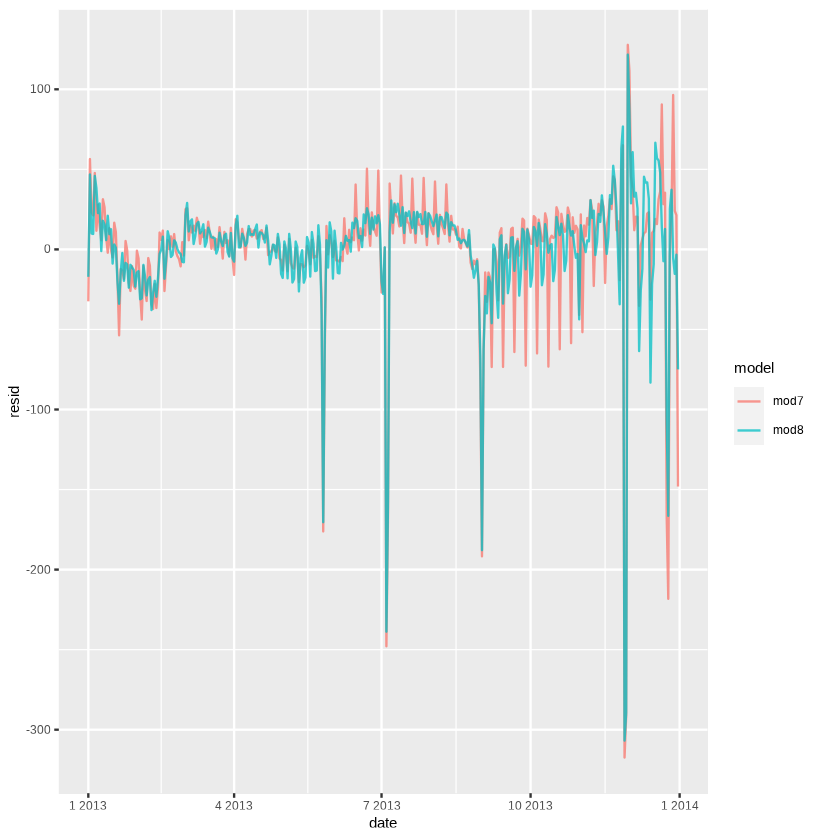

In [115]:
daily %>%
  gather_residuals(mod7, mod8) %>%
  ggplot(aes(x = date, y = resid, color = model)) +
  geom_line(alpha = 0.75)

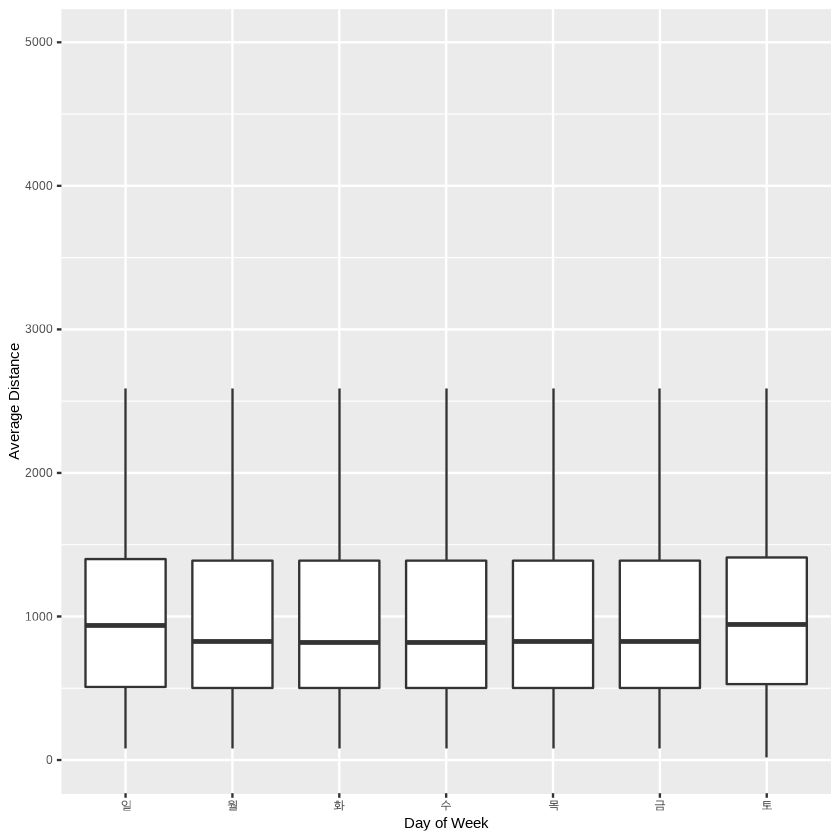

In [117]:
# 7
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  geom_boxplot(outlier.shape = NA) + # box-plot 이상치 숨기기
  labs(x = "Day of Week", y = "Average Distance")

No summary function supplied, defaulting to `mean_se()`



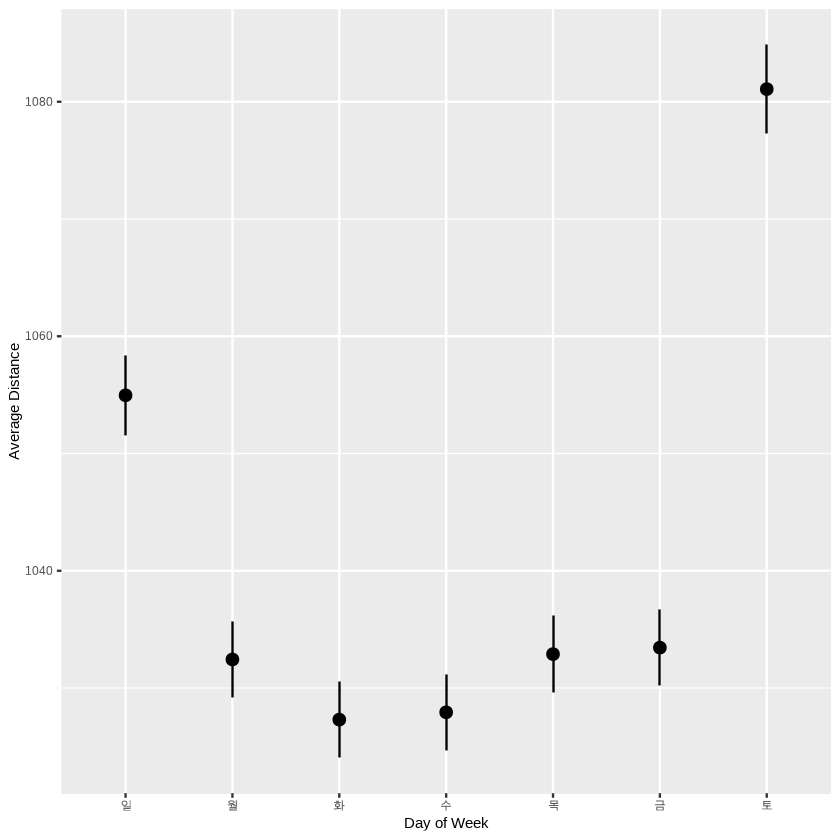

In [118]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  stat_summary() +
  labs(x = "Day of Week", y = "Average Distance")

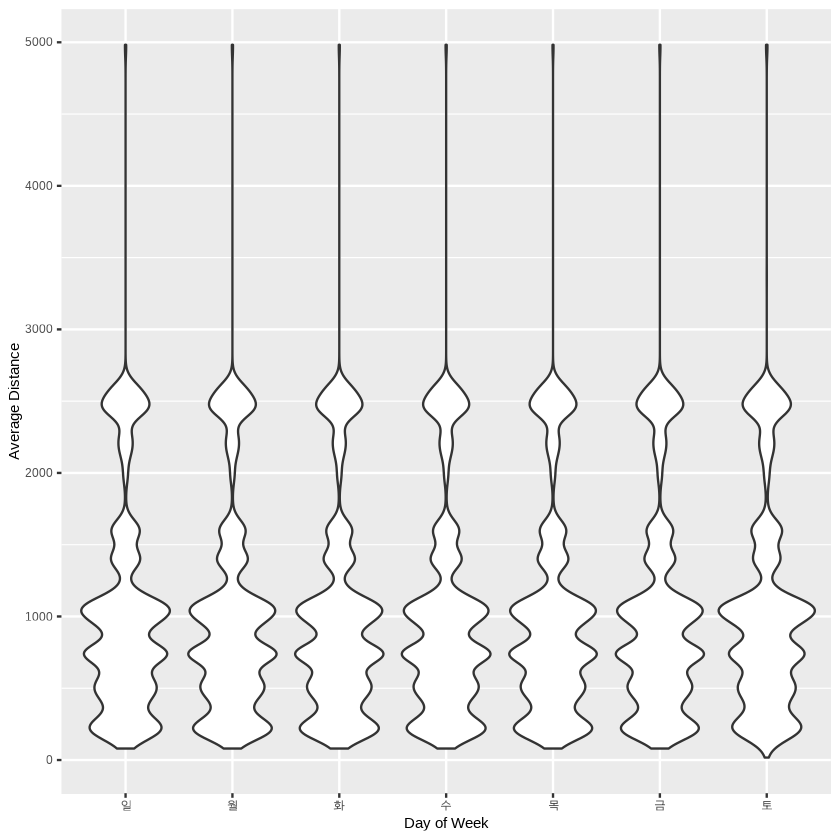

In [119]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  geom_violin() +
  labs(x = "Day of Week", y = "Average Distance")

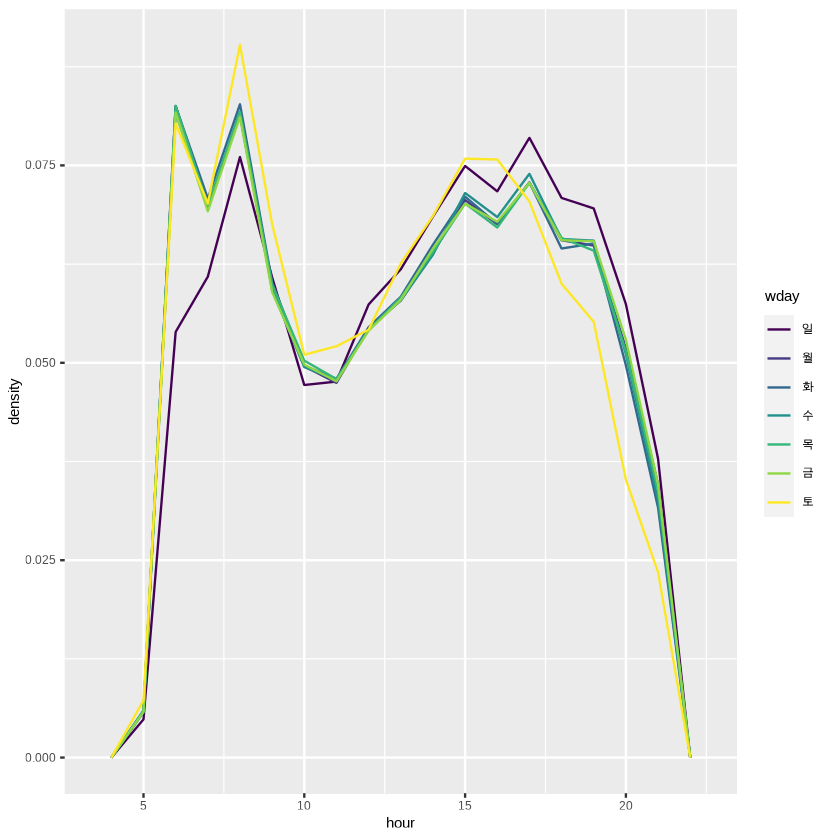

In [120]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000, hour >= 5, hour <= 21
  ) %>%
  ggplot(aes(x = hour, color = wday, y = ..density..)) +
  geom_freqpoly(binwidth = 1)

`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.


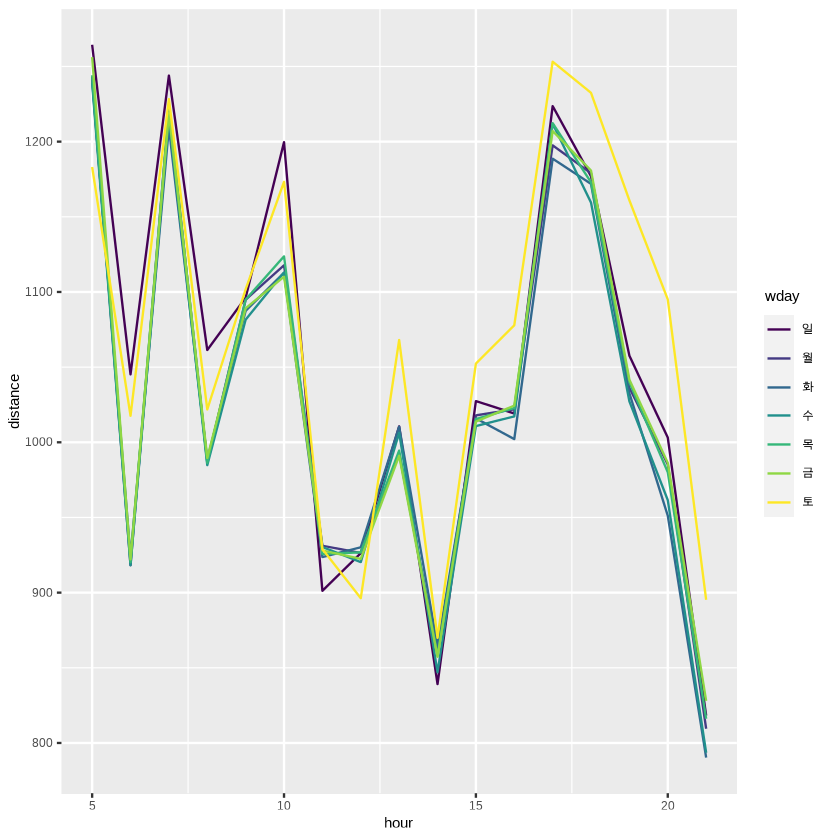

In [121]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000,
    hour >= 5, hour <= 21
  ) %>%
  group_by(wday, hour) %>%
  summarise(distance = mean(distance)) %>%
  ggplot(aes(x = hour, color = wday, y = distance)) +
  geom_line()

`summarise()` has grouped output by 'wday'. You can override using the `.groups` argument.


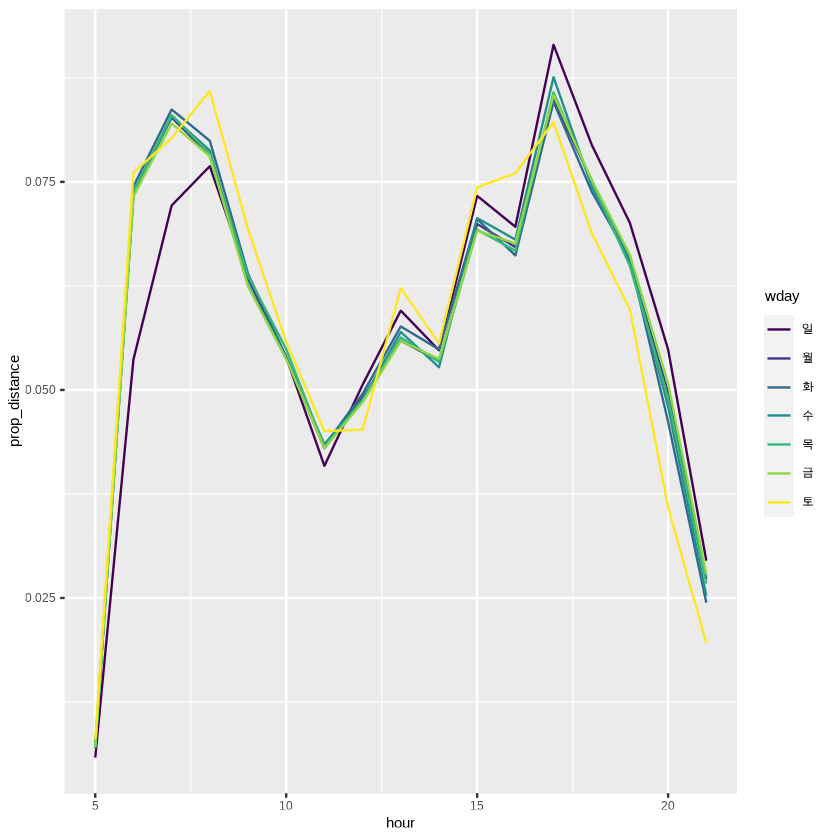

In [122]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000,
    hour >= 5, hour <= 21
  ) %>%
  group_by(wday, hour) %>%
  summarise(distance = sum(distance)) %>%
  group_by(wday) %>%
  mutate(prop_distance = distance / sum(distance)) %>%
  ungroup() %>%
  ggplot(aes(x = hour, color = wday, y = prop_distance)) +
  geom_line()

- 일요일에 출발하는 사람들은 월요일엔 어딘가에 도착해야 하는 비즈니스 여행자일 가능성이 크다고 가정
- 만약 이 가설이 사실이라면 비행거리가 먼, 일요일 저녁 항공편이 많을 것이라고 예상할 것이다.

- 요일별 평균 비행 거리를 비교하면 일요일 비행이 두 번째로 길다. 
- 토요일 비행은 평균적으로 가장 길다. 토요일은 정기적으로 예정된 단기 비즈니스가 더 적기 때문에 평균적으로 가장 긴 항공편이 있을 수 있다.
* 따라서 가설은 기각

# A tibble: 365 x 8
   date           n wday   resid term   wday2     wday3             month
   <date>     <int> <ord>  <dbl> <fct>  <chr>     <chr>             <fct>
 1 2013-01-01   842 화    -109.  spring 화        holiday           1    
 2 2013-01-02   943 수     -19.7 spring 수        day after holiday 1    
 3 2013-01-03   914 목     -51.8 spring 목        목                1    
 4 2013-01-04   915 금     -52.5 spring 금        금                1    
 5 2013-01-05   720 토     -24.6 spring 토-spring 토                1    
 6 2013-01-06   832 일     -59.5 spring 일        일                1    
 7 2013-01-07   933 월     -41.8 spring 월        월                1    
 8 2013-01-08   899 화     -52.4 spring 화        화                1    
 9 2013-01-09   902 수     -60.7 spring 수        수                1    
10 2013-01-10   932 목     -33.8 spring 목        목                1    
# ... with 355 more rows


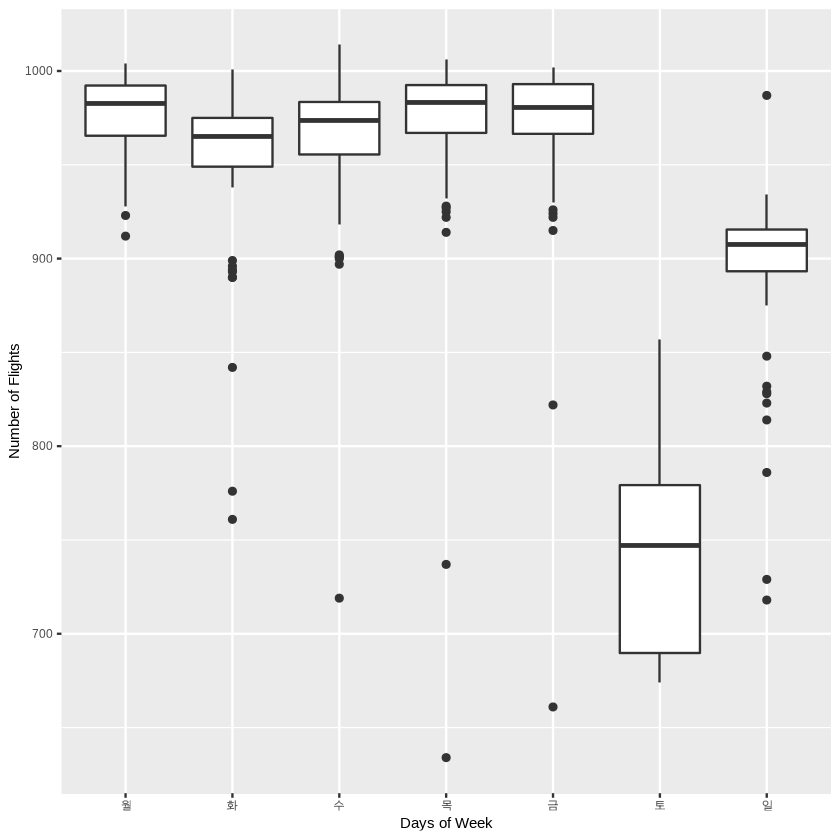

In [133]:
# 8
# 일주일이 월요일로 시작하도록 요인의 수준을 설정
daily <- daily %>% 
        mutate(wday = wday(date, label = T)) %>% print

ggplot(daily, aes(x = fct_relevel(wday, c("월", "화", "수", "목", "금", "토")), 
                  y = n)) + 
    geom_boxplot() + 
    ylab("Number of Flights") + xlab("Days of Week")